<a href="https://colab.research.google.com/github/Abtin-Ghorbani/mastrs_project_XAI_pneumonia_detection/blob/main/masters_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dawnload dataset from Kaggle**

In [ ]:
from google.colab import drive
import os
import shutil
import kagglehub
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q Kaggle
from google.colab import files
files.upload()
import os
# فقط در صورت نبود فایل zip، دانلود کن
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print(" Dataset ZIP already exists")
# فقط اگر فولدر chest_xray نیست، unzip کن
if not os.path.exists("dataset/chest_xray"):
    !unzip -q chest-xray-pneumonia.zip -d dataset
else:
    print(" Dataset already extracted")
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#  دانلود فقط اگر فایل ZIP هنوز وجود نداره
if not os.path.exists("chest-xray-pneumonia.zip"):
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print("Dataset ZIP already exists")

# ✅ استخراج فقط اگر فولدر اصلی chest_xray هنوز ساخته نشده
if not os.path.exists("dataset/chest_xray"):
    !unzip -n chest-xray-pneumonia.zip -d dataset
    !rm -rf dataset/__MACOSX  # حذف فایل‌های مزاحم مک
else:
    print("Dataset already extracted")


Streaming output truncated to the last 5000 lines.
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: d

In [ ]:
import os

base_dir = '/content/dataset/chest_xray'
print(os.listdir(base_dir))#folder names

['test', '__MACOSX', 'train', 'chest_xray', 'val']


# **task 1 data preproccessing**

In [ ]:
import os
import shutil
import random

# مسیر داده‌های اصلی و مسیر ذخیره‌ی داده‌های جدید
base_dir = 'dataset/chest_xray'
new_base = 'dataset/chest_xray_balanced'

# ساخت پوشه‌ی جدید اگه وجود نداره
os.makedirs(new_base, exist_ok=True)


In [ ]:
normal_all = []
pneumonia_all = []

for folder in ['train', 'test', 'val']:
    normal_path = os.path.join(base_dir, folder, 'NORMAL')
    pneumonia_path = os.path.join(base_dir, folder, 'PNEUMONIA')

    normal_all += [os.path.join(normal_path, f) for f in os.listdir(normal_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    pneumonia_all += [os.path.join(pneumonia_path, f) for f in os.listdir(pneumonia_path) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]


In [ ]:
min_len = min(len(normal_all), len(pneumonia_all))

normal_all = random.sample(normal_all, min_len)
pneumonia_all = random.sample(pneumonia_all, min_len)

print(f"✅ After balancing: {len(normal_all)} NORMAL and {len(pneumonia_all)} PNEUMONIA")


✅ After balancing: 1583 NORMAL and 1583 PNEUMONIA


In [ ]:
def split_data(file_list, train_ratio=0.7, val_ratio=0.2):
    random.shuffle(file_list)
    total = len(file_list)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    return file_list[:train_end], file_list[train_end:val_end], file_list[val_end:]

normal_train, normal_val, normal_test = split_data(normal_all)
pneumonia_train, pneumonia_val, pneumonia_test = split_data(pneumonia_all)


In [ ]:
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# مسیرهای خروجی نهایی
for label, train, val, test in zip(
    ['NORMAL', 'PNEUMONIA'],
    [normal_train, pneumonia_train],
    [normal_val, pneumonia_val],
    [normal_test, pneumonia_test]
):
    copy_files(train, os.path.join(new_base, 'train', label))
    copy_files(val, os.path.join(new_base, 'val', label))
    copy_files(test, os.path.join(new_base, 'test', label))


In [ ]:
for split in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_base, split, label)
        print(f"{split.upper()} - {label}: {len(os.listdir(folder))} images")


TRAIN - NORMAL: 1108 images
TRAIN - PNEUMONIA: 1108 images
VAL - NORMAL: 316 images
VAL - PNEUMONIA: 316 images
TEST - NORMAL: 159 images
TEST - PNEUMONIA: 159 images


In [10]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32
base_dir = 'dataset/chest_xray_balanced'

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'val'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'test'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 2216 files belonging to 2 classes.
Found 632 files belonging to 2 classes.
Found 318 files belonging to 2 classes.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for images, labels in train_ds.take(1):  # فقط یک batch می‌گیریم
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())  # چاپ لیبل‌های واقعی

Images shape: (32, 224, 224, 3)
Labels shape: (32, 1)
Labels: [[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


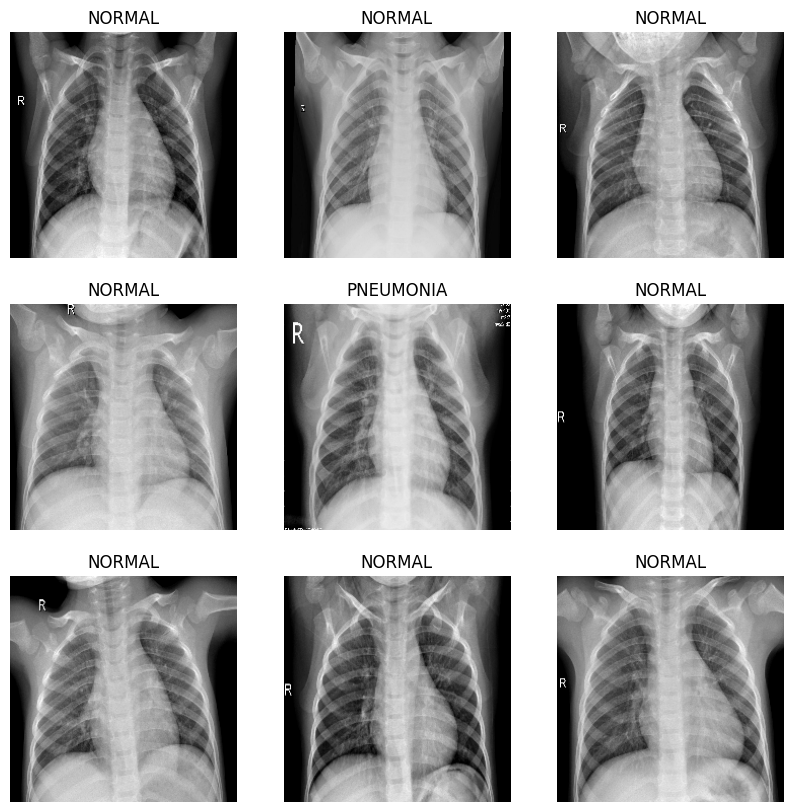

In [13]:
import matplotlib.pyplot as plt

class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# **Normalization**

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [15]:
def preprocess(image, label):
    image = preprocess_input(image)  # between mobile net [-1, 1]
    return image, label
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# **buld and Train CNN model for pneumonia classification**

In [16]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [17]:
# Load the base MobileNetV2 model without the top classification layers
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False# Freeze the base model so its weights do not change during training

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# **buil model **

In [18]:
# Build the full model on top of MobileNetV2
model_mobilenet = models.Sequential([
    base_model,   # Pretrained convolutional base
    layers.GlobalAveragePooling2D(),  # Reduce feature map to vector (1280)
    layers.Dropout(0.2),   #to prevent overfitting
    layers.Dense(1, activation='sigmoid') #  Pneumonia or normal
])

# **compile the model **

In [19]:
# Compile the model with optimizer, loss, and metric
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',                                # For binary classification
    metrics=['accuracy']
)

# **train model with images**

In [20]:
# Train the model using early stopping
history = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        # tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 258ms/step - accuracy: 0.6090 - loss: 0.6701 - val_accuracy: 0.7579 - val_loss: 0.5565
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7410 - loss: 0.5503 - val_accuracy: 0.8275 - val_loss: 0.4695
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8106 - loss: 0.4697 - val_accuracy: 0.8655 - val_loss: 0.4076
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8521 - loss: 0.4126 - val_accuracy: 0.8766 - val_loss: 0.3625
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8835 - loss: 0.3657 - val_accuracy: 0.8924 - val_loss: 0.3299
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8809 - loss: 0.3349 - val_accuracy: 0.8987 - val_loss: 0.3044
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9021 - loss: 0.3043 - val_accuracy: 0.9066 - val_loss: 0.2845
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8955 - loss: 0.2977 - val_accuracy: 0.9098 -

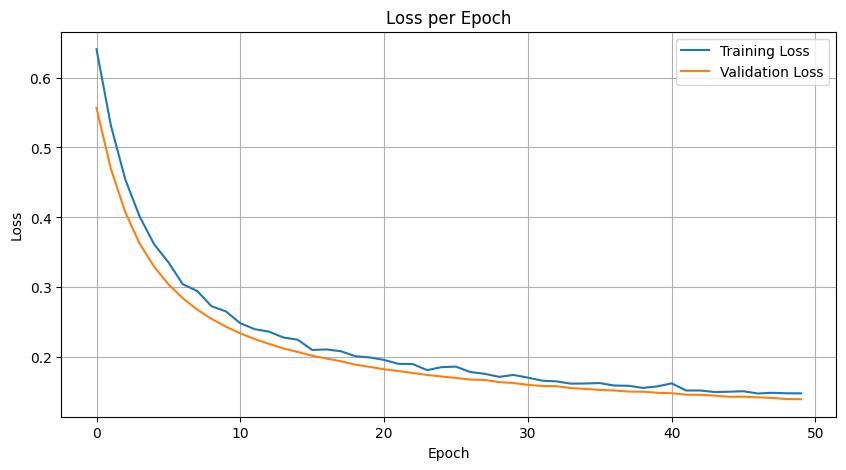

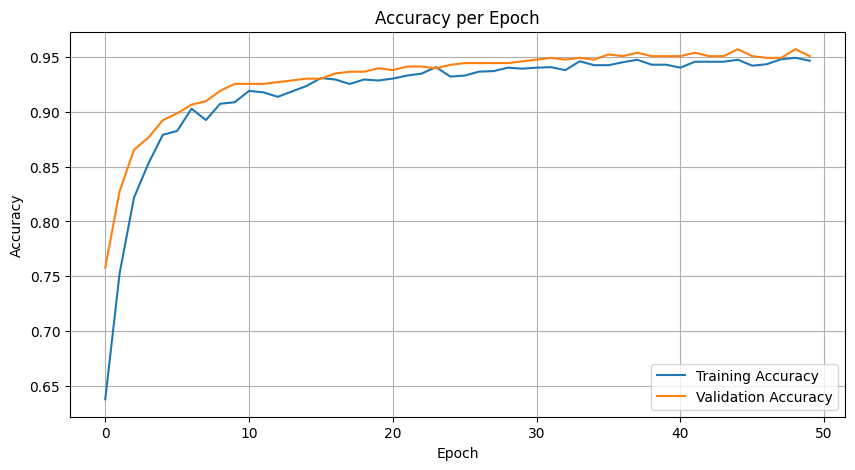

In [21]:
# prompt: write a code to show loss / epoch

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**save model tranfer learning**

In [22]:
model_mobilenet.save("mobilenetv2_transfer_only_final.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
0.99969625


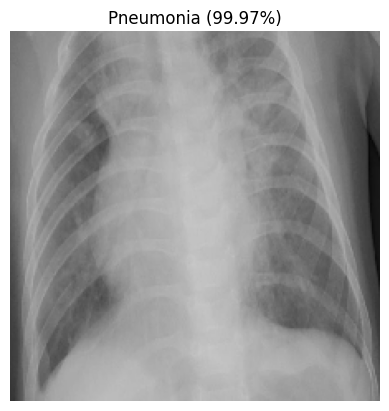

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load model
model = model_mobilenet
# Load and preprocess image
img_path = '/content/dataset/balanced_dataset/test/PNEUMONIA/person1167_bacteria_3113.jpeg'  # Update path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
prediction = model.predict(img_array)
print(prediction[0][0])
result = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"
confidence = prediction[0][0] if result == "Pneumonia" else 1 - prediction[0][0]

# Display
plt.imshow(img)
plt.title(f"{result} ({confidence:.2%})")
plt.axis('off')
plt.show()

# **evaluate model**

In [24]:
# Evaluate the model on test data
test_loss, test_acc = model_mobilenet.evaluate(test_ds)
print(f"Test Accuracy for mobile net: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 795ms/step - accuracy: 0.9217 - loss: 0.1984
Test Accuracy for mobile net: 0.9308


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: predicts and labels
y_true_befor = []
y_pred_befor = []
for images, labels in test_ds:
    preds_befor = model_mobilenet.predict(images)
    preds_befor = (preds_befor > 0.6).astype("int32")  # آستانه‌ی sigmoid
    y_true_befor.extend(labels.numpy())
    y_pred_befor.extend(preds_befor)

# Step 2 evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_true_befor, y_pred_befor))

print("\nClassification Report for transfer learning:")
print(classification_report(y_true_befor, y_pred_befor, target_names=['NORMAL', 'PNEUMONIA']))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
[[151   8]
 [ 15 144]]

Classification Report for transfer learning:
              precision    recall  f1-score   support

      NORMAL       0.91      0.95      0.93       159
   PNEUMONIA       0.95      0.91      0.93       159

    accuracy                           0.93       318
   macro avg       0.93      0.93      0.93       318
weighted avg       0.93      0.93      0.93       318



In [26]:
# prompt: write a code to save this model_mobilenet tu goggle drive in this folder /content/drive/MyDrive/masters project

model_save_path = '/content/drive/MyDrive/masters project/mobilenet_balanced_model.keras'
model_mobilenet.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/masters project/mobilenet_balanced_model.keras


# **fine tune model**